In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import string
import re
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 


C:\Users\konate\anaconda3_1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
DATA_PATH = "C:/Users/konate/Desktop/IA_kaagle/Data"
train_df = pd.read_json(DATA_PATH+"/train.json").set_index('Id')
test_df = pd.read_json(DATA_PATH+"/test.json").set_index('Id')
train_label = pd.read_csv(DATA_PATH+"/train_label.csv").set_index('Id')
label_decode=pd.read_csv(DATA_PATH+"/categories_string.csv")

# Compréhension et traitement des données


In [3]:
train_df.head()

,description,gender
Id,,
0,She is also a Ronald D. Asmus Policy Entrepre...,F
1,He is a member of the AICPA and WICPA. Brent ...,M
2,Dr. Aster has held teaching and research posi...,M
3,He runs a boutique design studio attending cl...,M
4,"He focuses on cloud security, identity and ac...",M


In [4]:
train_df.tail()

,description,gender
Id,,
217192,A member of the UWA Cultural Collections Boar...,M
217193,Kelly has worked globally leading teams of co...,F
217194,He's the lead author of a recent study that f...,M
217195,She specializes in the theoretical and pedago...,F
217196,Since she was 10 years old she has become a m...,F


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217197 entries, 0 to 217196
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  217197 non-null  object
 1   gender       217197 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB


* Analyse de la variable gender 

In [8]:
print(round(((train_df[train_df['gender']=='M'].shape[0])/train_df.shape[0])*100),'%', 'Hommes')

54 % Hommes


In [9]:
print(round(((train_df[train_df['gender']=='F'].shape[0])/train_df.shape[0])*100),'%', 'Hommes')

46 % Hommes


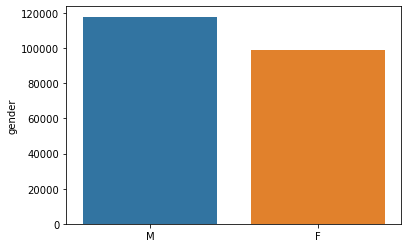

In [10]:
sns.barplot(x=['M', 'F'],y=train_df['gender'].value_counts());

*Notre base contient plus d'hommes que de femmes* 

In [5]:
#Nom des jobs
jobs=set(label_decode.iloc[:,0].to_list())

In [6]:
train_df_copy=train_df.copy()

In [7]:
#corpus de texte (regroupement de toutes les descriptions)
all_text = ' '.join([text for text in train_df['description']])
print('Nombre de mots dans all_text:', len(all_text))

Nombre de mots dans all_text: 86926725


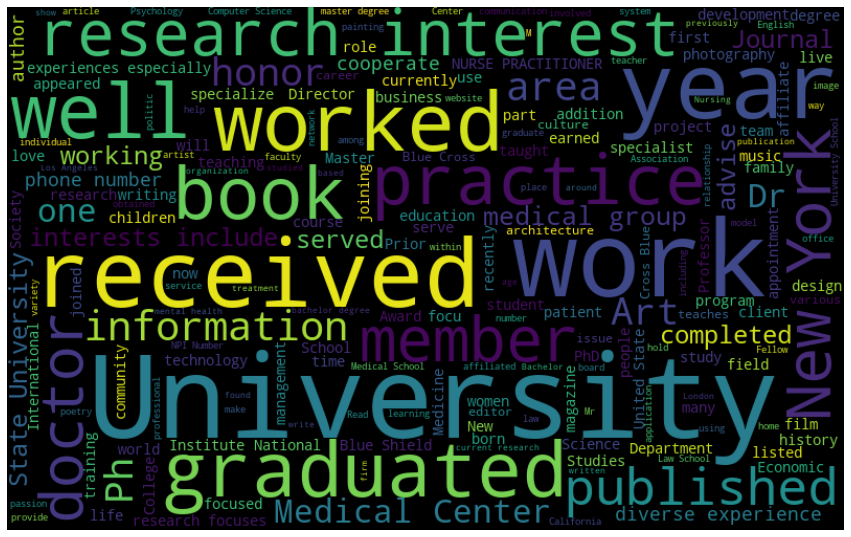

In [14]:
#Nuage de mots pour voir les mots pertinents
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(all_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [8]:
label_decode.columns=['jobs','jobs_code']
jobs=label_decode.jobs.to_list()
code=label_decode.jobs_code.to_list()
dic=dict(zip(code,jobs))


In [9]:
all_text[1:100]

'She is also a Ronald D. Asmus Policy Entrepreneur Fellow with the German Marshall Fund and is a Vis'

* Nettoyage du texte, suppression de la ponctuation et des stopwords 

In [10]:
#suppression des nombres
def remove_nums(s):
    return re.sub('[^\s]*[0-9]+[^\s]*', "", s)
train_df['description'] = train_df['description'].map(remove_nums)

In [11]:
#suppression des ponctuations
def remove_punctuation(s):
    global punctuation
    for p in punctuation:
        s = s.replace(p, '')
    return s

train_df['description'] = train_df['description'].map(remove_punctuation)

In [12]:
#convertir en miniscule
train_df['description'] = train_df['description'].map(lambda x: x.lower())

In [13]:
#corpus de texte (regroupement de toutes les descriptions)
all_text = ' '.join([text for text in train_df['description']])
print('Nombre de mots dans all_text:', len(all_text))

Nombre de mots dans all_text: 83774585


*Après le néttoyage du texte, nous obtennons moins de mots qu'auparavant*

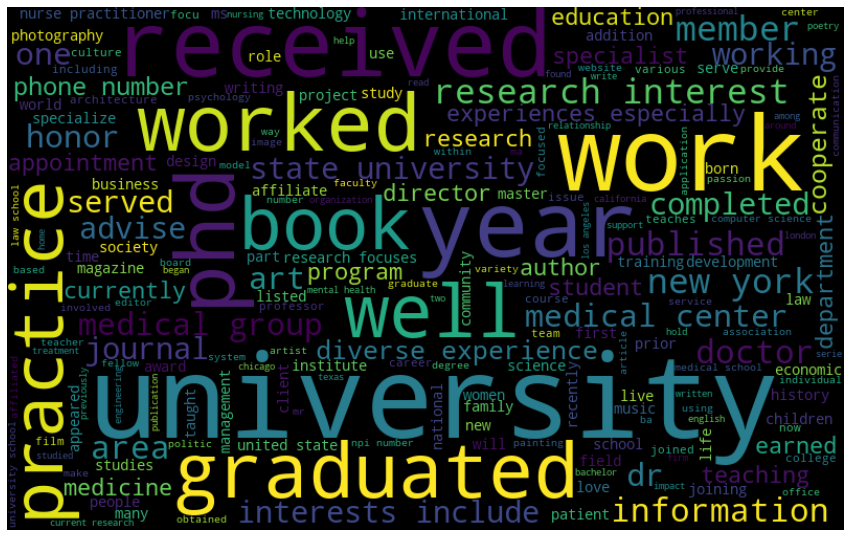

In [23]:
#Nuage de mots pour voir les mots pertinents après néttoyage du texte
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(all_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [14]:
#clean le texte à nouveau en prenant en compte les stopwords
docs=all_text.split()
mini_word_list = [x.lower() for x in docs]
text_clean = [w.lower() for w in mini_word_list if w not in stopwords and w.isalpha()]
text_clean = ' '.join(text.lower() for text in text_clean)
print('Nombre de mots dans text_clean:', len(text_clean))

Nombre de mots dans text_clean: 61756956


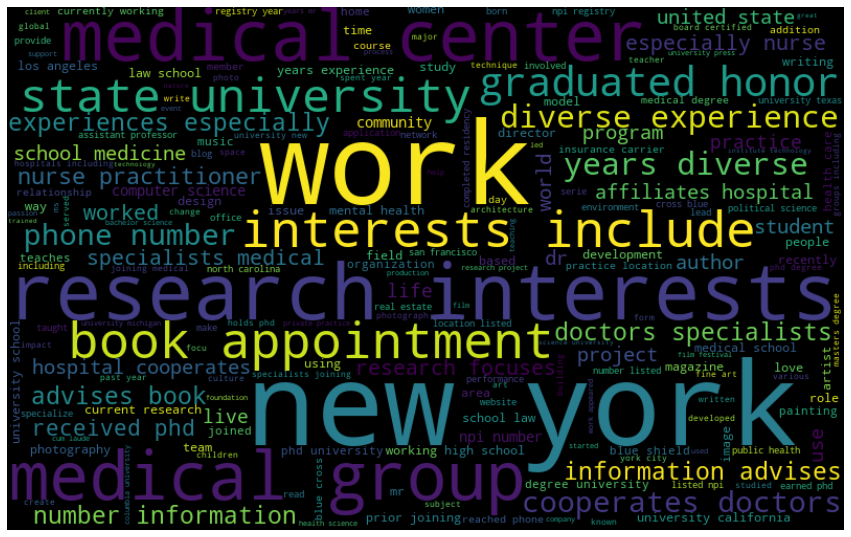

In [25]:
#Nuage de mots pour voir les mots pertinents après néttoyage du texte
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(text_clean)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

*les mots les plus importants sont liés à la medcine,l'education .*

In [15]:
#Augmenter le nombre de variable en comptant le nombre de fois qu'un métier est contenu dans une description
for i in label_decode.jobs:
    train_df[i]=train_df['description'].str.contains(i).astype(int)
    

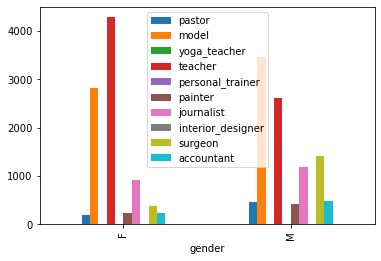

In [16]:
train_df.groupby(['gender']).sum()[jobs[:10]].plot.bar()

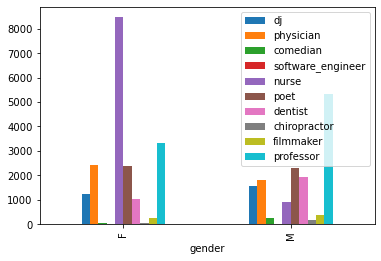

In [17]:
train_df.groupby(['gender']).sum()[jobs[10:20]].plot.bar()

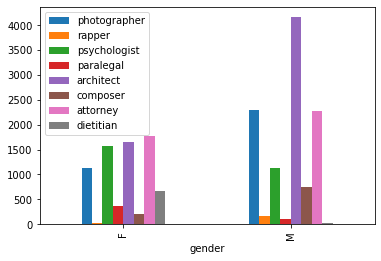

In [18]:
train_df.groupby(['gender']).sum()[jobs[20:28]].plot.bar()

In [24]:
#stemming
words_list=text_clean.split()
ps=PorterStemmer()

stemming_words = [ps.stem(w) for w in words_list]

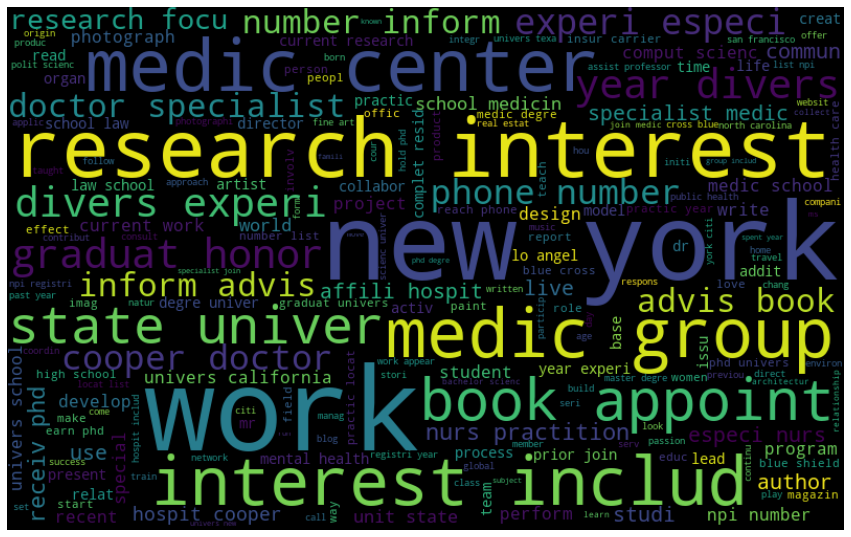

In [26]:
text_stem=' '.join(stemming_words)
#Nuage de mots pour voir les mots pertinents après stemming
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(text_stem)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [16]:
#Lemmantisation
lem=WordNetLemmatizer()
lem_words = [lem.lemmatize(w) for w in words_list]


NameError: name 'words_list' is not defined

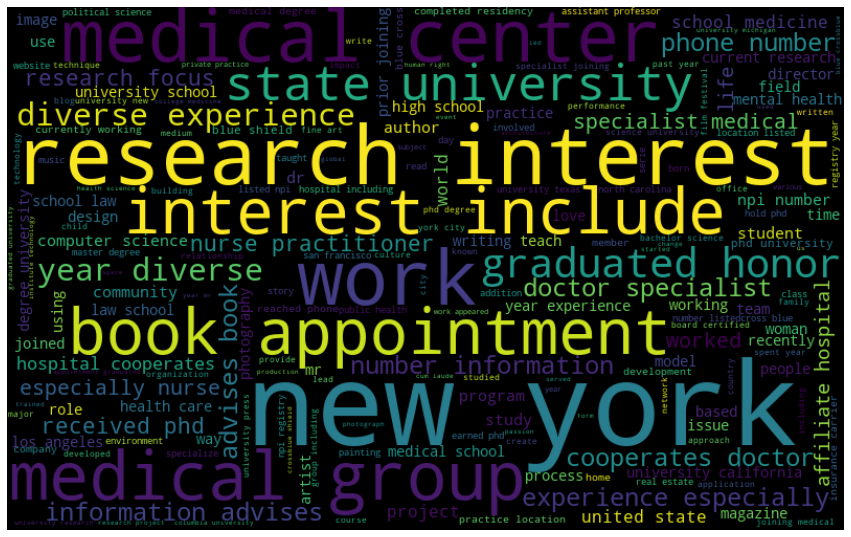

In [33]:
text_lem=' '.join(lem_words)
#Nuage de mots pour voir les mots pertinents après stemming
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(text_lem)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [34]:
# Regarder les propriétés grammaticales de notre corpus 
tokens = word_tokenize(text_lem)

answer = nltk.pos_tag(tokens)
answer_pos = [a[1] for a in answer]

all_pos = pd.Series(answer_pos)
all_pos.value_counts().head()

NN     4229141
JJ     1600867
VBD     347069
VBG     344084
RB      199599
dtype: int64

In [17]:
train_df.isnull().sum()

description          0
gender               0
pastor               0
model                0
yoga_teacher         0
teacher              0
personal_trainer     0
painter              0
journalist           0
interior_designer    0
surgeon              0
accountant           0
dj                   0
physician            0
comedian             0
software_engineer    0
nurse                0
poet                 0
dentist              0
chiropractor         0
filmmaker            0
professor            0
photographer         0
rapper               0
psychologist         0
paralegal            0
architect            0
composer             0
attorney             0
dietitian            0
dtype: int64

In [ ]:
#reconnaissance d'entité nommée
def return_NER(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte et le label pour chaque entité
    return [(X.text, X.label_) for X in doc.ents]

In [18]:
# Vectorization
transformer = TfidfVectorizer().fit(train_df["description"].values)
print("NB features: %d" %(len(transformer.vocabulary_)))
X_train = transformer.transform(train_df["description"].values)
X_test = transformer.transform(test_df["description"].values)
X_train

NB features: 256235


<217197x256235 sparse matrix of type '<class 'numpy.float64'>'
	with 9526263 stored elements in Compressed Sparse Row format>

In [21]:
X_train.shape

(217197, 256235)